In [108]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score,RocCurveDisplay, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
import nltk
from nltk.tokenize import word_tokenize

# Load Data

In [109]:
data = pd.read_csv("data/data.csv", encoding='ISO-8859-1') # Handle weird ascii values
data.head(1)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion


In [110]:
# Renaming
data = data.rename(columns={
    "tweet_text":"tweet",
    "emotion_in_tweet_is_directed_at":"directed_at",
    "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"
})
data.head(1)

,tweet,directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion


# EDA

## is_na

In [111]:
data.isna().sum()

tweet             1
directed_at    5802
emotion           0
dtype: int64

In [112]:
# Removing the NaN tweet
data = data[data['tweet'].isna() == False]
data.isna().sum()

tweet             0
directed_at    5801
emotion           0
dtype: int64

In [113]:
# Lots of missing data here, fill directed_at with unknown 
data['directed_at'].fillna("Unknown", inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet        9092 non-null   object
 1   directed_at  9092 non-null   object
 2   emotion      9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


C:\Users\Greg\AppData\Local\Temp\ipykernel_37100\532631997.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['directed_at'].fillna("Unknown", inplace = True)


In [114]:
data.directed_at.value_counts()

directed_at
Unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: count, dtype: int64

In [115]:
data.emotion.value_counts()

emotion
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

### Dropping "I can't tell" since it provides no value for encoding

In [116]:
data = data[data['emotion'] != "I can't tell"]
data.emotion.value_counts()

emotion
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: count, dtype: int64

### Removing duplicates, (This is why the tokenizer kept returning different lengths)

In [117]:
data = data.drop_duplicates(subset='tweet')
data

,tweet,directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",Unknown,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",Unknown,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,Unknown,No emotion toward brand or product


# Preprocess

### Remove @, #, https, link, rt, then tokenize and lemmatize

In [118]:
def preprocess_tweet(text):
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    
    # Remove @ and # mentions and hashtags
    text = re.sub(r'[@#]\w+', '', text)
    
    # Remove non-alphanumeric characters (excluding punctuation)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove the word "rt" and lemmatize other tokens, filtering out non-alphabetic tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token != 'rt 'and token != 'link']
    
    # Join tokens back into a single string
    return ' '.join(lemmatized_tokens)


### Apply preprocess

In [119]:
data['tweet'] = data['tweet'].apply(preprocess_tweet)

emotion_mapping = {
    "Negative emotion": -1,
    "No emotion toward brand or product": 0,
    "Positive emotion": 1
}

data['emotion'] = data['emotion'].map(emotion_mapping)

data

,tweet,directed_at,emotion
0,i have a iphone after hr tweeting at it wa dea...,iPhone,-1
1,know about awesome ipadiphone app that youll l...,iPad or iPhone App,1
2,can not wait for also they should sale them do...,iPad,1
3,i hope this year festival isnt a crashy a this...,iPad or iPhone App,-1
4,great stuff on fri marissa mayer google tim or...,Google,1
...,...,...,...
9088,ipad everywhere,iPad,1
9089,wave buzz rt we interrupt your regularly sched...,Unknown,0
9090,google zeiger a physician never reported poten...,Unknown,0
9091,some verizon iphone customer complained their ...,Unknown,0


# Class Imbalance

We a 5x imbalance between negative and positive emotions for our binary classifier. We will use smote majority class undersampler to handle this imbalance, as well as updating out confusion matricies to be normalized. This will transform the confusion matrix to reflect normalized proportions, rather than absolute counts. By normalizing the confusion matrix, we can better understand the performance of the classifier in terms of precision, recall, and overall accuracy across the different classes. This approach helps to visualize the proportion of correct and incorrect classifications relative to the total number of instances in each class, which is particularly useful when dealing with imbalanced datasets.


In [120]:
data.emotion.value_counts()

emotion
 0    5372
 1    2968
-1     569
Name: count, dtype: int64

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

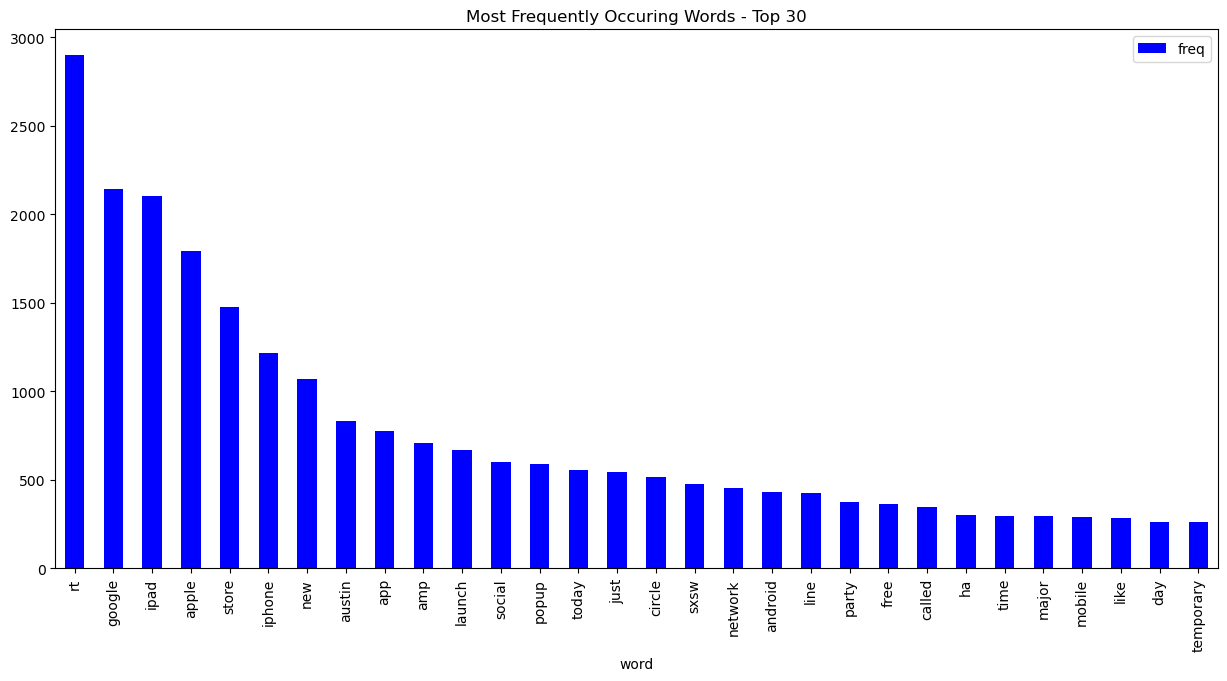

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(data['tweet'])
sum_words = words.sum(axis=0)
words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

# Evaluation Function

In [122]:
def evaluate_model_binary(y_test, y_pred, clf_pipe):
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix

    disp = ConfusionMatrixDisplay.from_estimator(clf_pipe, X_test, y_test, display_labels=['Negative', 'Positive'],
               cmap=plt.cm.Blues, normalize='true')

    plt.title("Normalized Confusion Matrix")
    plt.show()

    # Probability scores for ROC
    y_pred_proba = clf_pipe.predict_proba(X_test)[:, 1]  # Ensure clf_pipe is a fitted pipeline
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Plot ROC Curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Binary Classifier (Baseline)

In [123]:
data_binary = data[data['emotion'] != 0]
X = data_binary['tweet']
y = data_binary['emotion']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Classification Report:
              precision    recall  f1-score   support

          -1       0.16      0.17      0.17       140
           1       0.84      0.83      0.84       745

    accuracy                           0.73       885
   macro avg       0.50      0.50      0.50       885
weighted avg       0.74      0.73      0.73       885



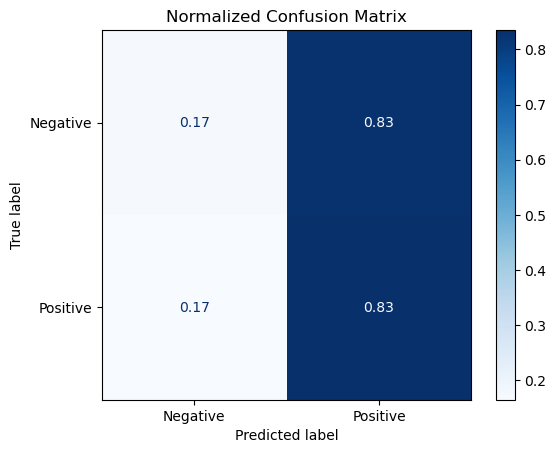

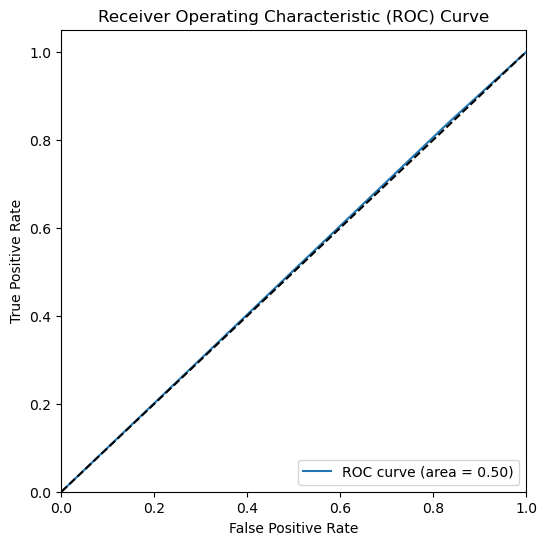

In [124]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

clf_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Text vectorization
    ('clf', DummyClassifier(strategy='stratified', random_state=42))  # Classification
])
clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)


clf_pipe.fit(X_train, y_train)
y_pred = clf_pipe.predict(X_test)

evaluate_model_binary(y_test, y_pred, clf_pipe)

In [125]:
# Nearly a 5x class imbalance here
data_binary.emotion.value_counts()

emotion
 1    2968
-1     569
Name: count, dtype: int64

# MultinomialNB + Stop Words + SMOTE Undersampling

In [126]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{'clf__alpha': 1.0, 'clf__fit_prior': True, 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 5000, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': None}
Classification Report:
              precision    recall  f1-score   support

          -1       0.39      0.74      0.51       140
           1       0.94      0.78      0.85       745

    accuracy                           0.77       885
   macro avg       0.66      0.76      0.68       885
weighted avg       0.85      0.77      0.80       885



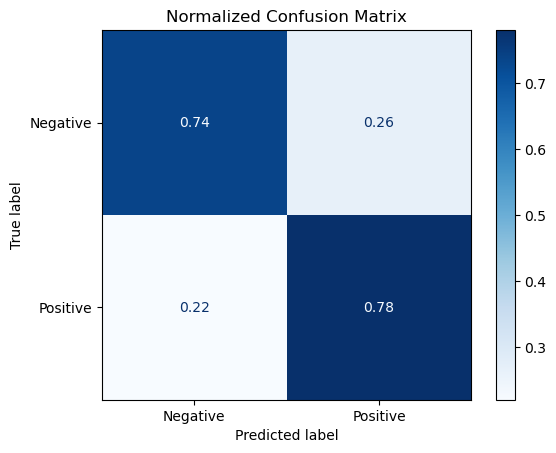

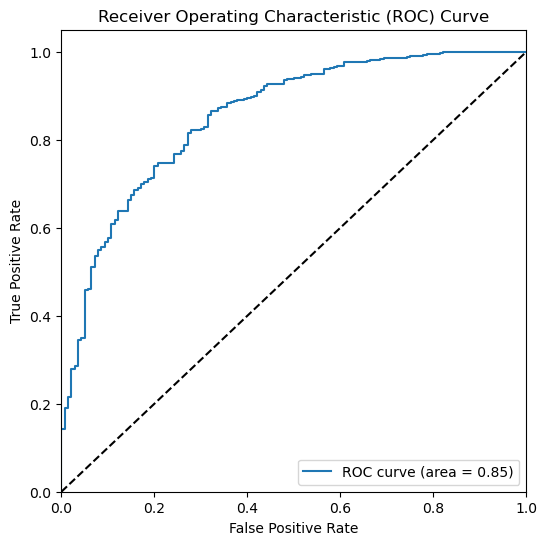

In [127]:
clf_pipe_oversample = ImbPipeline([
    ('vectorizer', TfidfVectorizer()),  # Text vectorization
    #('oversample', RandomOverSampler()),  # Minority oversampling
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf', MultinomialNB())  # Multinomial Naive Bayes classifier
])

param_grid = {
    'clf__alpha': [1.0],
    'clf__fit_prior': [True],
    'vectorizer__max_df': [0.5],
    'vectorizer__max_features': [5000],
    'vectorizer__min_df': [1],
    'vectorizer__ngram_range': [(1, 1)],
    'vectorizer__stop_words': [None]
}
grid_search = GridSearchCV(estimator=clf_pipe_oversample, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 10,error_score='raise')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)

print("Best parameters found:")
print(grid_search.best_params_)


# Evaluate the best model
evaluate_model_binary(y_test, y_pred, best_model)

# Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'vectorizer__max_df': 0.85, 'vectorizer__min_df': 2, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}
Classification Report:
              precision    recall  f1-score   support

          -1       0.34      0.74      0.46       140
           1       0.94      0.72      0.82       745

    accuracy                           0.73       885
   macro avg       0.64      0.73      0.64       885
weighted avg       0.84      0.73      0.76       885



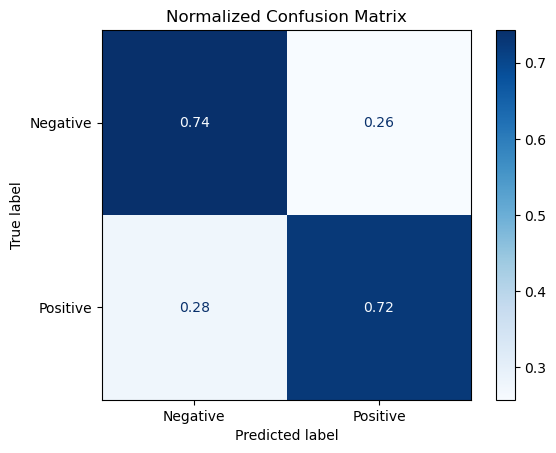

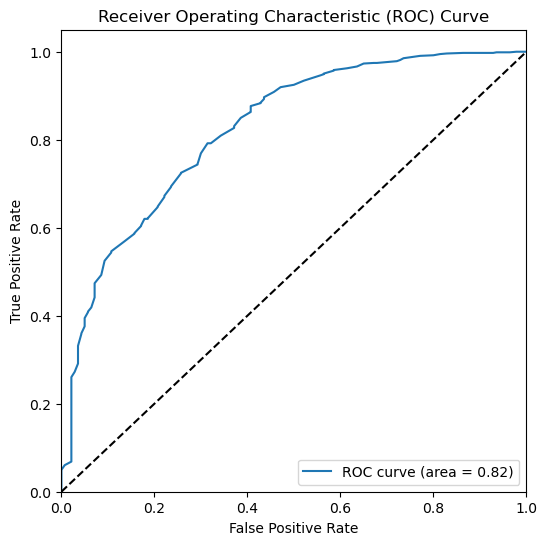

In [128]:
from sklearn.ensemble import RandomForestClassifier

clf_pipe = ImbPipeline([
    ('vectorizer', TfidfVectorizer()),  # Placeholder parameters, will be tuned
    #('oversample', RandomOverSampler()),  # Minority oversampling
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))  # Placeholder parameters, will be tuned
])

param_grid = {
    'clf__max_depth': [None],
    'clf__max_features': ['sqrt'],
    'clf__min_samples_leaf': [1],
    'clf__min_samples_split': [2],
    'vectorizer__max_df': [0.85],
    'vectorizer__min_df': [2], 
    'vectorizer__ngram_range': [(1, 2)],
    'vectorizer__stop_words': [None]
}
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 5)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)



# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)

evaluate_model_binary(y_test, y_pred, best_model)


# Logistic Regression

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{'clf__Cs': 10, 'clf__cv': 5, 'clf__max_iter': 100, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}
Classification Report:
              precision    recall  f1-score   support

          -1       0.39      0.76      0.52       140
           1       0.94      0.78      0.85       745

    accuracy                           0.78       885
   macro avg       0.67      0.77      0.69       885
weighted avg       0.86      0.78      0.80       885



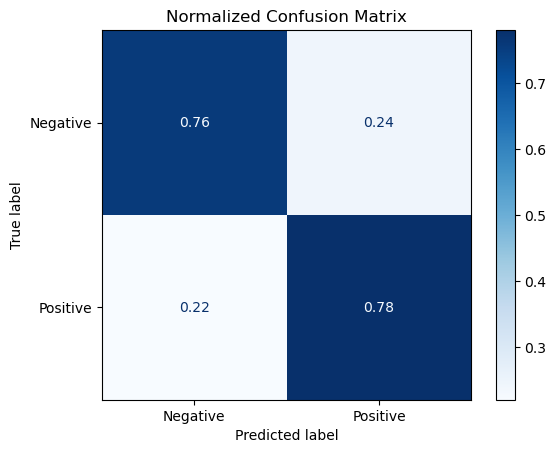

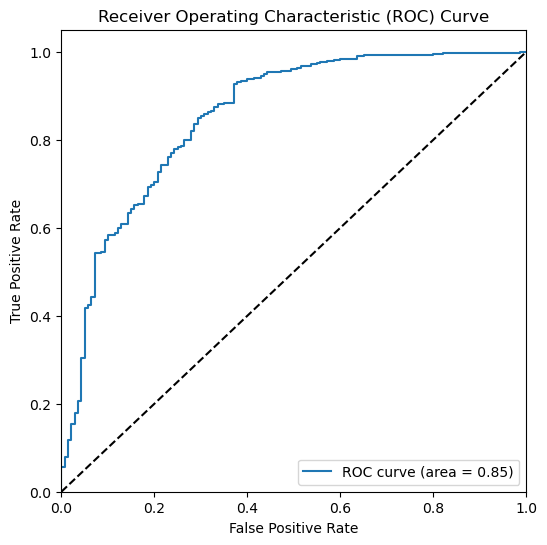

In [129]:
clf_pipe = ImbPipeline([
    ('vectorizer', TfidfVectorizer(stop_words = 'english',norm='l2')),  # Placeholder parameters, will be tuned
    #('oversample', RandomOverSampler()),  # Minority oversampling
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf', LogisticRegressionCV(class_weight='balanced', random_state=42, 
                                 cv=3, Cs=1, solver='liblinear'))])

# Define the parameter grid
param_grid = {
    'clf__Cs': [10],  # Number of regularization parameters
    'clf__cv': [5],  # Number of folds in cross-validation
    'clf__max_iter': [100],  # Maximum number of iterations
    'vectorizer__max_df': [0.75], 
    'vectorizer__min_df': [1],
    'vectorizer__ngram_range': [ (1, 2)], 
    'vectorizer__stop_words': [None]
}


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=5)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
evaluate_model_binary(y_test, y_pred, best_model)

In [137]:
def evaluate_model_multi(y_true, y_pred, model, X_test, n_class=3):
    """
    Evaluate the performance of a multi-class classifier by generating:
    - ROC AUC curves
    - Classification reports
    - Confusion matrices
    
    Args:
    y_true: True labels for the test set
    y_pred: Predicted labels by the model
    model: Trained model
    X_test: Test features (for obtaining probabilities)
    n_class: Number of classes (default is 3)
    """
    
    # Classification report
    print("CLASSIFICATION REPORT")
    print("------------------------------------------")
    print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=[-1, 0, 1])
    y_pred_prob = model.predict_proba(X_test)
    
    # Compute ROC curve and ROC AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    plt.figure(figsize=(10, 7))
    for i in range(n_class):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'ROC curve for class {i} (area = {roc_auc[i]:.2f})')
    
    # Plot ROC curve for the model
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='best')
    plt.show()

In [138]:
data_multi = data.copy()
X = data_multi['tweet']
y = data_multi['emotion']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:
{'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'vectorizer__max_df': 0.75, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}
CLASSIFICATION REPORT
------------------------------------------
              precision    recall  f1-score   support

    Negative       0.78      0.18      0.29       156
     Neutral       0.68      0.92      0.78      1333
    Positive       0.69      0.35      0.46       739

    accuracy                           0.68      2228
   macro avg       0.71      0.48      0.51      2228
weighted avg       0.69      0.68      0.64      2228



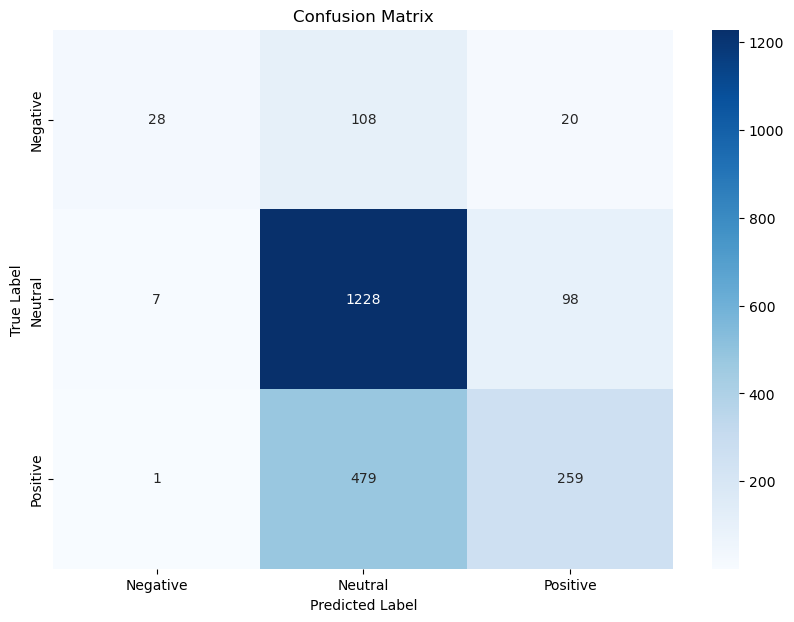

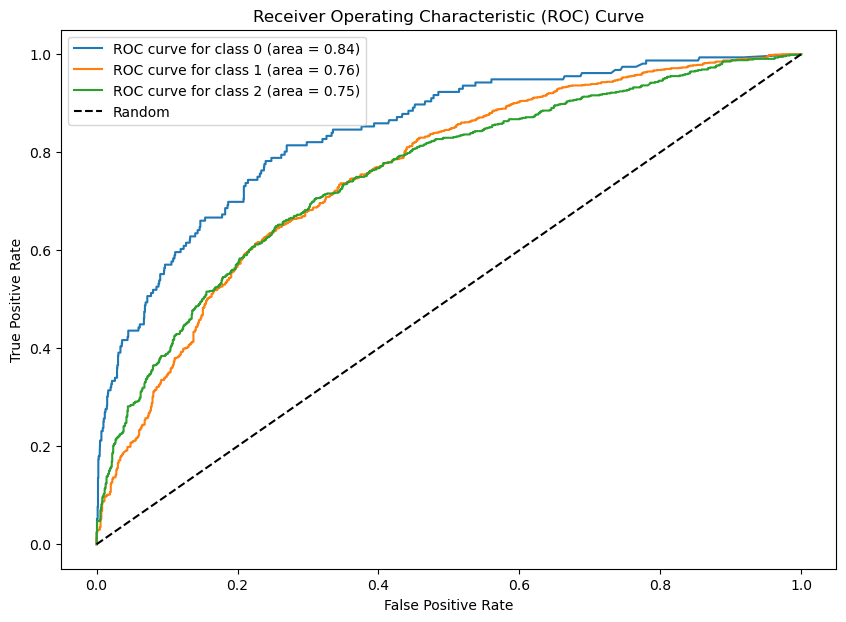

In [139]:
clf_pipe = ImbPipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english', norm='l2')),
    ('clf', RandomForestClassifier(random_state=42))  # Random Forest Classifier
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'vectorizer__max_df': [0.75], 
    'vectorizer__min_df': [1],
    'vectorizer__ngram_range': [(1, 2)], 
    'vectorizer__stop_words': [None],
    'clf__n_estimators': [100, 200],  # Number of trees in the forest
    'clf__max_depth': [None, 10, 20],  # Max depth of the tree
    'clf__min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'clf__min_samples_leaf': [1, 2]    # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf_pipe, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=5)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred = best_model.predict(X_test)
evaluate_model_multi(y_test, y_pred, best_model, X_test, n_class=3)